In [1]:
import warnings
warnings.filterwarnings('ignore')


In [2]:
import matplotlib.pyplot as plt
import math
import numpy as np
import torch
import torch.nn as nn
import pandas as pd
import seaborn as sns
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from matplotlib.pyplot import scatter, figure
from scipy import stats
from numpy.ma.core import outer
from sys import stderr


In [3]:
start = -7
end = 7
n = 300
batch_size = 16

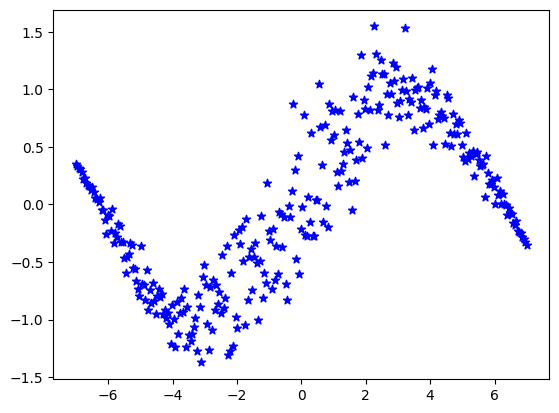

In [4]:
def sample_dataset(start, end, n):
    np.random.seed(0)
    x = np.linspace(start, end, n)
    sample_mean = [math.sin(i/2) for i in x]

    sample_var = [abs((abs(start)+abs(end))/2 - abs(i))/16 for i in x]
    y = stats.norm(sample_mean, sample_var).rvs(random_state=0)
    return x, y

x_train, y_train = sample_dataset(start, end, n)
scatter(x_train, y_train, c="blue", marker="*")

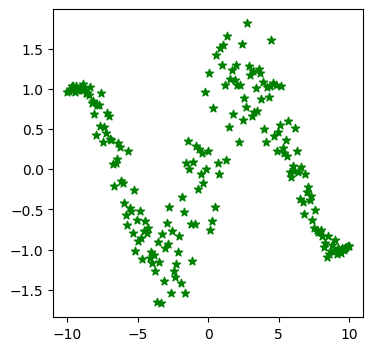

In [5]:
figure(figsize=(4, 4))
# Not exactely the same distribution, but works for now
x_test, y_test = sample_dataset(-10, 10, 200)
scatter(x_test, y_test, c="green", marker="*")

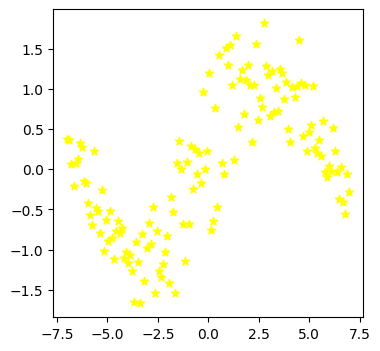

In [6]:
#Plotting In Training Distribution Data Points in the Test Set
# Filter the data to retain only the desired ranges
mask =  (x_test >= -7) &  (x_test <= 7) # Select the ranges -10 to -7 and 7 to 10
x_test_idd = x_test[mask]
y_test_idd = y_test[mask]

plt.figure(figsize=(4, 4))
plt.scatter(x_test_idd, y_test_idd, c="yellow", marker="*")

plt.show()


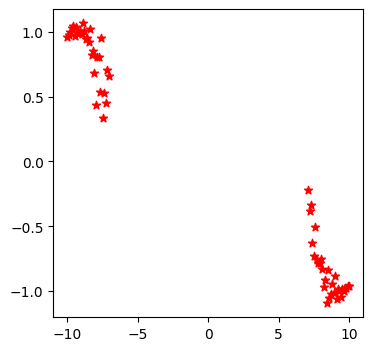

In [7]:
#Plotting Out of Training Distribution Data Points in the Test Set
# Filter the data to retain only the desired ranges
mask = (x_test >= -10) & (x_test < -7) | (x_test > 7) & (x_test <= 10) # Select the ranges -10 to -7 and 7 to 10
x_test_oodd = x_test[mask]
y_test_oodd = y_test[mask]

plt.figure(figsize=(4, 4))
plt.scatter(x_test_oodd, y_test_oodd, c="red", marker="*")

plt.show()


In [8]:

# Train
tensor_x = torch.Tensor(x_train).unsqueeze(1)
tensor_y = torch.Tensor(y_train).unsqueeze(1)
train_dataset = TensorDataset(tensor_x, tensor_y)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

#Test for OODD (Out of Data Distribution)
tensor_x_test_oodd = torch.Tensor(x_test_oodd).unsqueeze(1)
tensor_y_test_oodd = torch.Tensor(y_test_oodd).unsqueeze(1)
test_dataset_oodd = TensorDataset(tensor_x_test_oodd, tensor_y_test_oodd)
test_loader_oodd = DataLoader(test_dataset_oodd, batch_size=batch_size, shuffle=True)

#Test for IDD (In Data Distribution)
tensor_x_test_idd = torch.Tensor(x_test_idd).unsqueeze(1)
tensor_y_test_idd = torch.Tensor(y_test_idd).unsqueeze(1)
test_dataset_idd = TensorDataset(tensor_x_test_idd, tensor_y_test_idd)
test_loader_idd = DataLoader(test_dataset_idd, batch_size=batch_size, shuffle=True)

# Test
tensor_x_test = torch.Tensor(x_test).unsqueeze(1)
tensor_y_test = torch.Tensor(y_test).unsqueeze(1)
test_dataset = TensorDataset(tensor_x_test, tensor_y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [9]:
class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        hidden_size = 60

        # We only have 1 input feature
        self.fc1 = nn.Linear(1, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.mu = nn.Linear(hidden_size, 1)
        self.var = nn.Linear(hidden_size, 1)

    def forward(self, x):
        h = torch.tanh(self.fc1(x))
        h = torch.tanh(self.fc2(h))
        mu = self.mu(h)
        # Exponential activation to enforce positive var
        # Arash: this might be a significant difference:
        var = torch.exp(self.var(h))
        return mu, var



In [10]:

sns.set(rc={'figure.figsize':(4, 4)})

def make_plot(model):
    # Get predictions
    mu, var = model(tensor_x_test)
    mu, sigma = mu.detach().numpy(), var.detach().numpy()**(1/2)
    # ~ 95% conf. interval (see https://en.wikipedia.org/wiki/1.96)
    y_vals = [mu, mu+2*sigma, mu-2*sigma]
    dfs = []
    # Create DF from predictions
    for i in range(3):
        data = {
              "x": list(tensor_x_test.squeeze().numpy()),
              "y": list(y_vals[i].squeeze())
        }
        temp = pd.DataFrame.from_dict(data)
        dfs.append(temp)
    df = pd.concat(dfs).reset_index()
    # Plot predictions with confidence
    sns_plot = sns.lineplot(data=df, x="x", y="y")
    # Highligh training range
    plt.axvline(x=start)
    plt.axvline(x=end)
    # Plot test data on top
    scatter(x_test, y_test, c="green", marker="*")
    plt.savefig("snn.png", dpi=300, bbox_inches='tight')  # Add this line
    plt.show()

In [11]:
#PLOTTING IN DATA DISTRIBUTION
sns.set(rc={'figure.figsize':(4, 4)})

def make_plot_idd(model):
    # Get predictions
    mu, var = model(tensor_x_test_idd)
    mu, sigma = mu.detach().numpy(), var.detach().numpy()**(1/2)

    # ~ 95% conf. interval (see https://en.wikipedia.org/wiki/1.96)
    y_vals = [mu, mu+2*sigma, mu-2*sigma]
    dfs = []

    # Create DF from predictions
    for i in range(3):
        data = {
              "x": list(tensor_x_test_idd.squeeze().numpy()),
              "y": list(y_vals[i].squeeze())
        }
        temp = pd.DataFrame.from_dict(data)
        dfs.append(temp)
    df = pd.concat(dfs).reset_index()

    # Plot predictions with confidence
    sns_plot = sns.lineplot(data=df, x="x", y="y")

    # Highligh training range
    plt.axvline(x=start)
    plt.axvline(x=end)

    # Plot test data on top
    scatter(x_test_idd, y_test_idd, c="yellow", marker="*", alpha=0.5)
    plt.show()

In [12]:
#PLOTTING OUT OF DATA DISTRIBUTION
sns.set(rc={'figure.figsize':(4, 4)})

def make_plot_oodd(model):
    # Get predictions
    mu, var = model(tensor_x_test_oodd)
    mu, sigma = mu.detach().numpy(), var.detach().numpy()**(1/2)

    # ~ 95% conf. interval (see https://en.wikipedia.org/wiki/1.96)
    y_vals = [mu, mu+2*sigma, mu-2*sigma]
    dfs = []

    # Create DF from predictions
    for i in range(3):
        data = {
              "x": list(tensor_x_test_oodd.squeeze().numpy()),
              "y": list(y_vals[i].squeeze())
        }
        temp = pd.DataFrame.from_dict(data)
        dfs.append(temp)
    df = pd.concat(dfs).reset_index()

    # Plot predictions with confidence
    sns_plot = sns.lineplot(data=df, x="x", y="y")

    # Highligh training range
    plt.axvline(x=start)
    plt.axvline(x=end)

    # Plot test data on top
    scatter(x_test_oodd, y_test_oodd, c="red", marker="*", alpha=0.5)
    plt.show()

In [13]:
net = SimpleNet()
print(net)
print("Params:", sum(p.numel() for p in net.parameters() if p.requires_grad))

SimpleNet(
  (fc1): Linear(in_features=1, out_features=60, bias=True)
  (fc2): Linear(in_features=60, out_features=60, bias=True)
  (mu): Linear(in_features=60, out_features=1, bias=True)
  (var): Linear(in_features=60, out_features=1, bias=True)
)
Params: 3902


In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Loss expects mean, variance and target
criterion = torch.nn.GaussianNLLLoss(eps=1e-02)
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [15]:
net.train()
net.to(device)

SimpleNet(
  (fc1): Linear(in_features=1, out_features=60, bias=True)
  (fc2): Linear(in_features=60, out_features=60, bias=True)
  (mu): Linear(in_features=60, out_features=1, bias=True)
  (var): Linear(in_features=60, out_features=1, bias=True)
)

In [16]:
def MLE_snn():
  net=SimpleNet()
  criterion = torch.nn.GaussianNLLLoss(eps=1e-02)
  optimizer = optim.Adam(net.parameters(), lr=0.001)
  net.train()
  net.to(device)
  for epoch in range(150):
    # Train loop
    for batch in train_loader:
        x = batch[0].to(device)
        y = batch[1].to(device)
        optimizer.zero_grad()
        mu, var = net(x)
        loss = criterion(mu, y, var)
        loss.backward()
        optimizer.step()
        criterionmse_train = nn.MSELoss()
        mse_train = criterionmse_train(mu, y)
    if epoch % 10 == 0:
        all_test_losses = []
        all_mse_test=[]
        # Test loop
        for batch in test_loader:
             x = batch[0].to(device)
             y = batch[1].to(device)
             mu, var = net(x)
             all_test_losses.append(criterion(mu, y, var).item())
             criterionmse_test = nn.MSELoss()
             all_mse_test.append(criterionmse_test(mu,y).item())
        test_loss = sum(all_test_losses)/len(all_test_losses)
        test_mse=sum(all_mse_test)/len(all_mse_test)
  make_plot(net)
  print(f"Epoch {epoch} | batch train loss: {loss} | test loss: {test_loss}")
  print(f"Epoch {epoch} |batch train mse:{mse_train}| test mse:{test_mse}")
  return loss, test_loss, mse_train, test_mse


In [17]:
def MLE_snn_idd():
  net=SimpleNet()
  criterion = torch.nn.GaussianNLLLoss(eps=1e-02)
  optimizer = optim.Adam(net.parameters(), lr=0.001)
  net.train()
  net.to(device)
  for epoch in range(150):
    # Train loop
    for batch in train_loader:
        x = batch[0].to(device)
        y = batch[1].to(device)
        optimizer.zero_grad()
        mu, var = net(x)
        loss = criterion(mu, y, var)
        loss.backward()
        optimizer.step()
        criterionmse_train = nn.MSELoss()
        mse_train = criterionmse_train(mu, y)
    if epoch % 10 == 0:
        all_test_losses = []
        all_mse_test=[]
        # Test loop
        for batch in test_loader_idd:
             x = batch[0].to(device)
             y = batch[1].to(device)
             mu, var = net(x)
             all_test_losses.append(criterion(mu, y, var).item())
             criterionmse_test = nn.MSELoss()
             all_mse_test.append(criterionmse_test(mu,y).item())
        test_loss = sum(all_test_losses)/len(all_test_losses)
        test_mse=sum(all_mse_test)/len(all_mse_test)

  make_plot_idd(net)

  print(f"Epoch {epoch} | batch train loss: {loss} | test loss: {test_loss}")
  print(f"Epoch {epoch} |batch train mse:{mse_train}| test mse:{test_mse}")
  return loss, test_loss, mse_train, test_mse


In [18]:
def MLE_snn_oodd():
  net=SimpleNet()
  criterion = torch.nn.GaussianNLLLoss(eps=1e-02)
  optimizer = optim.Adam(net.parameters(), lr=0.001)
  net.train()
  net.to(device)
  for epoch in range(150):
    # Train loop
    for batch in train_loader:
        x = batch[0].to(device)
        y = batch[1].to(device)
        optimizer.zero_grad()
        mu, var = net(x)
        loss = criterion(mu, y, var)
        loss.backward()
        optimizer.step()
        criterionmse_train = nn.MSELoss()
        mse_train = criterionmse_train(mu, y)
    if epoch % 10 == 0:
        all_test_losses = []
        all_mse_test=[]
        # Test loop
        for batch in test_loader_oodd:
             x = batch[0].to(device)
             y = batch[1].to(device)
             mu, var = net(x)
             all_test_losses.append(criterion(mu, y, var).item())
             criterionmse_test = nn.MSELoss()
             all_mse_test.append(criterionmse_test(mu,y).item())
        test_loss = sum(all_test_losses)/len(all_test_losses)
        test_mse=sum(all_mse_test)/len(all_mse_test)
  make_plot_oodd(net)
  print(f"Epoch {epoch} | batch train loss: {loss} | test loss: {test_loss}")
  print(f"Epoch {epoch} |batch train mse:{mse_train}| test mse:{test_mse}")
  return loss, test_loss, mse_train, test_mse


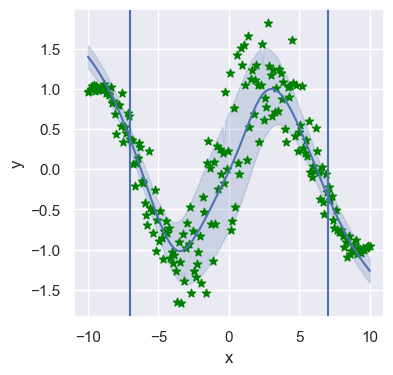

Epoch 149 | batch train loss: -1.6791013479232788 | test loss: 0.29505591896864086
Epoch 149 |batch train mse:0.03455733880400658| test mse:0.1494462487216179


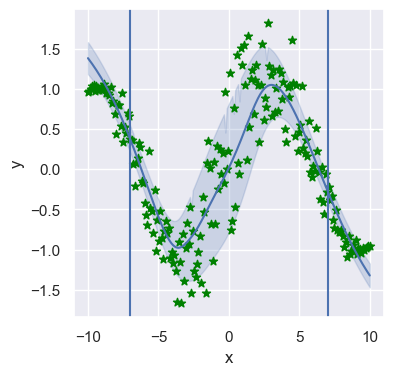

Epoch 149 | batch train loss: -1.1711150407791138 | test loss: 0.8349259472810305
Epoch 149 |batch train mse:0.031390029937028885| test mse:0.17089273436711386


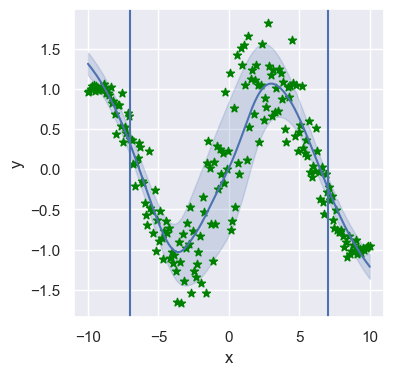

Epoch 149 | batch train loss: -1.1756644248962402 | test loss: 0.19433839733784014
Epoch 149 |batch train mse:0.01866396889090538| test mse:0.15139088636407486


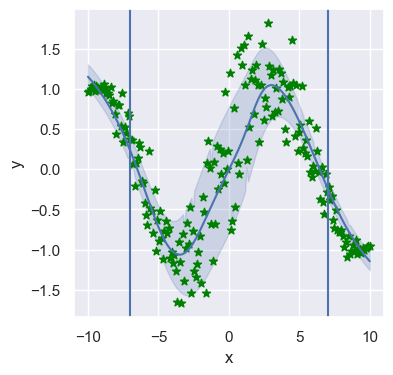

Epoch 149 | batch train loss: -0.9296385645866394 | test loss: 0.3498601454954881
Epoch 149 |batch train mse:0.12710201740264893| test mse:0.1532512645308788


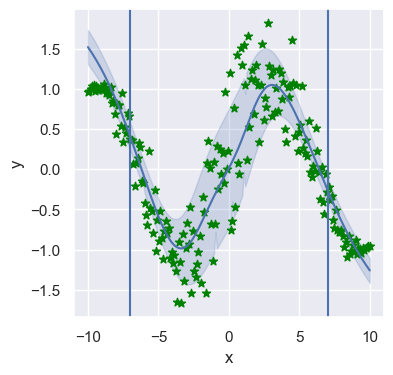

Epoch 149 | batch train loss: -0.8959779143333435 | test loss: 0.5264433278487279
Epoch 149 |batch train mse:0.11446263641119003| test mse:0.14919982850551605


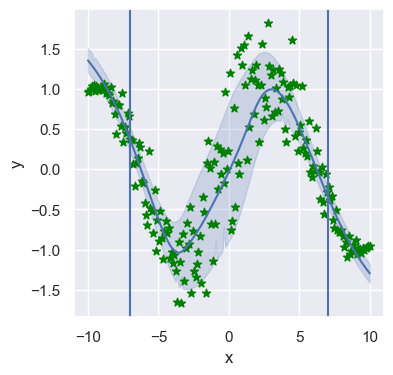

Epoch 149 | batch train loss: -1.3644753694534302 | test loss: 0.388745275254433
Epoch 149 |batch train mse:0.03592098131775856| test mse:0.1472532617358061


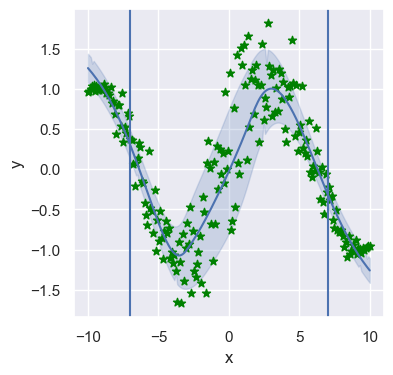

Epoch 149 | batch train loss: -1.3733197450637817 | test loss: 0.25520123885228085
Epoch 149 |batch train mse:0.087205670773983| test mse:0.15604252310899588


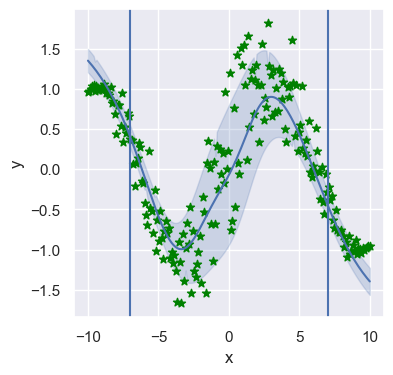

Epoch 149 | batch train loss: -1.3979288339614868 | test loss: 0.04683440350569212
Epoch 149 |batch train mse:0.030223675072193146| test mse:0.1379240837234717


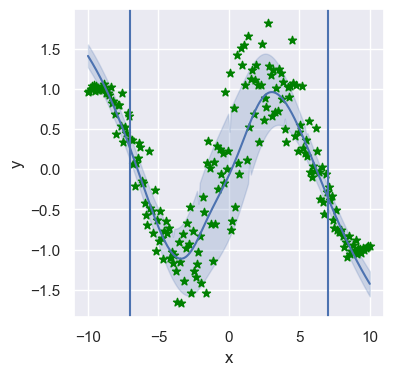

Epoch 149 | batch train loss: -1.2751661539077759 | test loss: 0.8025621513907726
Epoch 149 |batch train mse:0.039744630455970764| test mse:0.16256067500664637


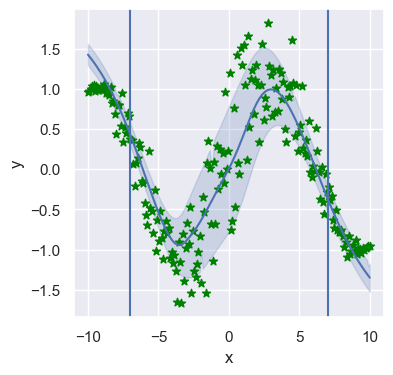

Epoch 149 | batch train loss: -1.2881983518600464 | test loss: 0.190084946843294
Epoch 149 |batch train mse:0.01338841300457716| test mse:0.14444112261900535


In [19]:
train_losses=[]
test_losses=[]
errors_train=[]
errors_test=[]
for i in range(10):
  tr_loss,test_loss,mse_tr,mse_test = MLE_snn()
  train_losses.append(tr_loss)
  test_losses.append(test_loss)
  errors_train.append(mse_tr)
  errors_test.append(mse_test)

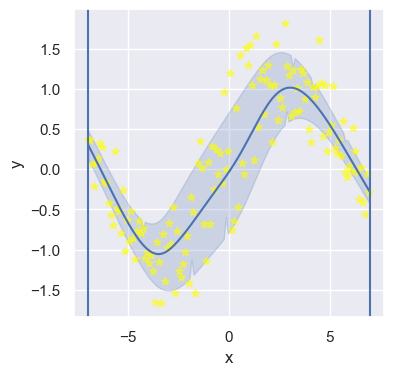

Epoch 149 | batch train loss: -1.3517762422561646 | test loss: 0.6834980729553435
Epoch 149 |batch train mse:0.06102336570620537| test mse:0.19229670448435676


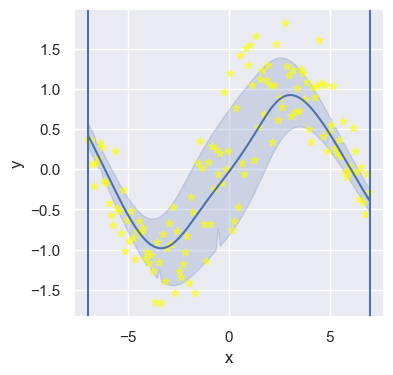

Epoch 149 | batch train loss: -1.0722483396530151 | test loss: 0.6750146879090203
Epoch 149 |batch train mse:0.08369144052267075| test mse:0.1942231117023362


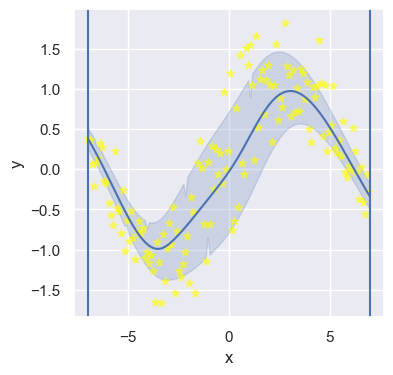

Epoch 149 | batch train loss: -1.2407945394515991 | test loss: 0.7169787916872237
Epoch 149 |batch train mse:0.055486422032117844| test mse:0.1986356410715315


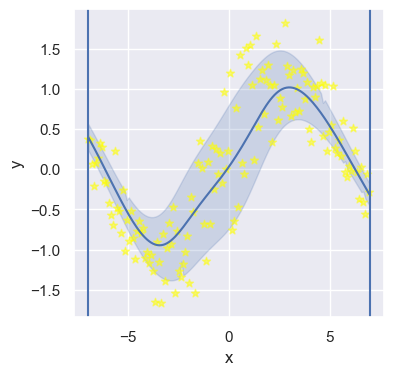

Epoch 149 | batch train loss: -1.2922934293746948 | test loss: 0.5030755350987116
Epoch 149 |batch train mse:0.08205924928188324| test mse:0.1859457931584782


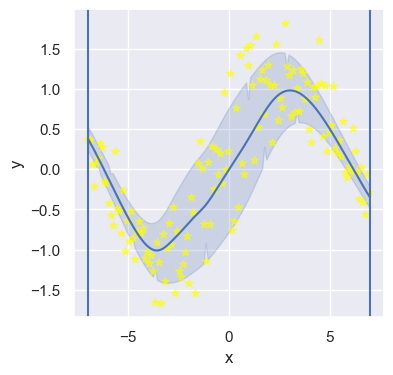

Epoch 149 | batch train loss: -1.077341914176941 | test loss: 0.5709521356556151
Epoch 149 |batch train mse:0.07497162371873856| test mse:0.18433555712302527


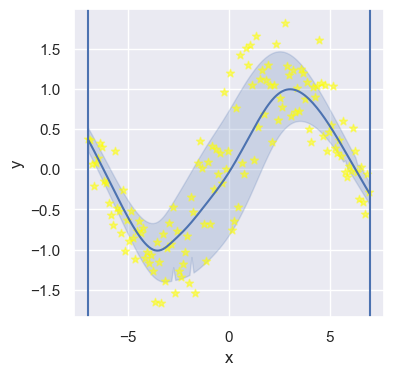

Epoch 149 | batch train loss: -1.3610574007034302 | test loss: 0.2871554179324044
Epoch 149 |batch train mse:0.04050939902663231| test mse:0.18788241512245601


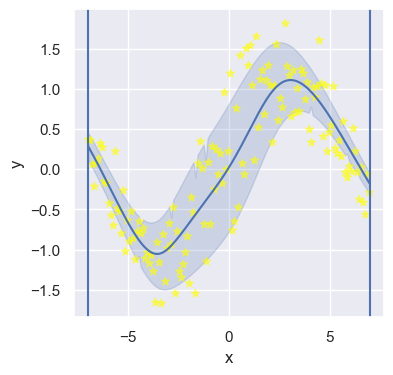

Epoch 149 | batch train loss: -0.7723290920257568 | test loss: 0.5860452916887071
Epoch 149 |batch train mse:0.11218173056840897| test mse:0.1937332029143969


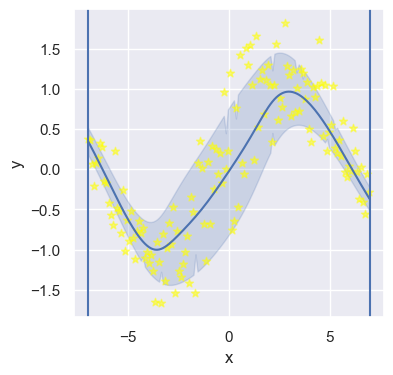

Epoch 149 | batch train loss: -1.1528968811035156 | test loss: 0.622616843216949
Epoch 149 |batch train mse:0.0452994741499424| test mse:0.19208186037010616


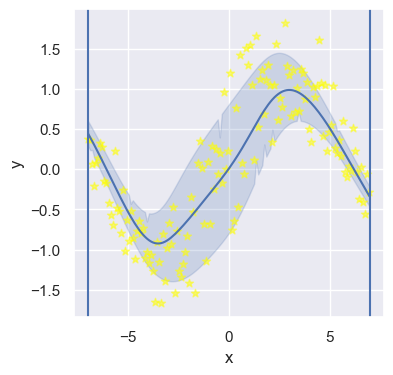

Epoch 149 | batch train loss: -1.555974006652832 | test loss: 0.4529923482073678
Epoch 149 |batch train mse:0.02789939194917679| test mse:0.1979399464196629


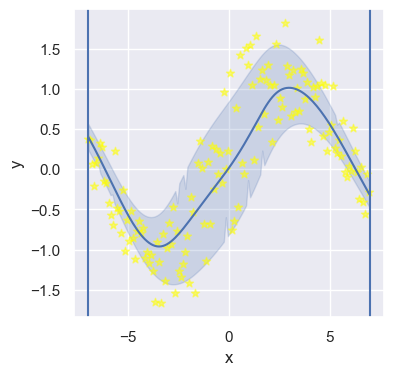

Epoch 149 | batch train loss: -1.1989214420318604 | test loss: 0.5472388548983468
Epoch 149 |batch train mse:0.0832393541932106| test mse:0.18480730967389214


In [20]:
train_losses_idd=[]
test_losses_idd=[]
errors_train_idd=[]
errors_test_idd=[]
for i in range(10):
  tr_loss,test_loss,mse_tr,mse_test = MLE_snn_idd()
  train_losses_idd.append(tr_loss)
  test_losses_idd.append(test_loss)
  errors_train_idd.append(mse_tr)
  errors_test_idd.append(mse_test)

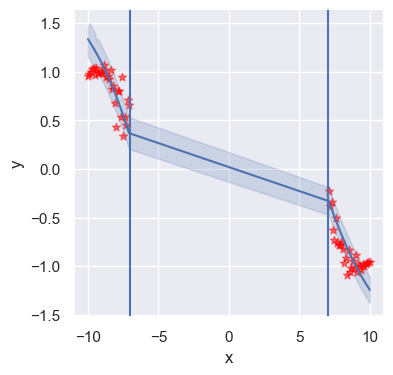

Epoch 149 | batch train loss: -1.0547014474868774 | test loss: -0.3920927904546261
Epoch 149 |batch train mse:0.0837712287902832| test mse:0.03820466669276357


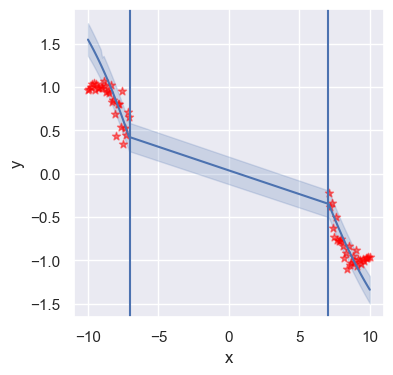

Epoch 149 | batch train loss: -0.8989443778991699 | test loss: 0.25664257258176804
Epoch 149 |batch train mse:0.12515467405319214| test mse:0.05118455272167921


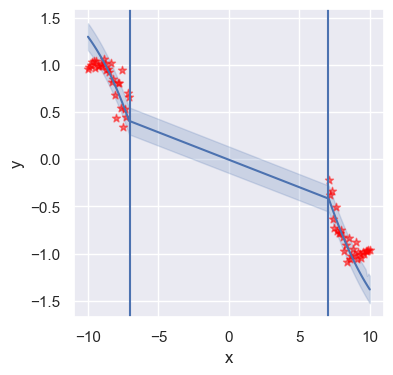

Epoch 149 | batch train loss: -1.2311935424804688 | test loss: -0.8551344498991966
Epoch 149 |batch train mse:0.032562874257564545| test mse:0.028949012514203787


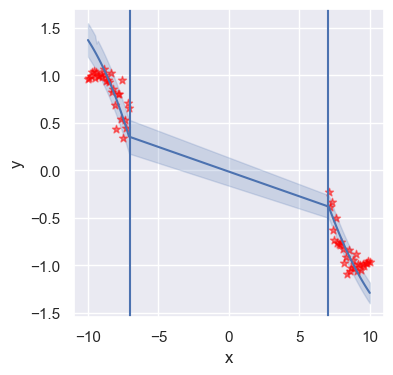

Epoch 149 | batch train loss: -0.45550286769866943 | test loss: 0.22236839681863785
Epoch 149 |batch train mse:0.17903673648834229| test mse:0.05049906950443983


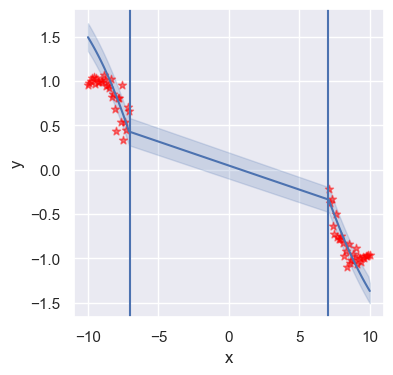

Epoch 149 | batch train loss: -1.3646718263626099 | test loss: 0.47675875946879387
Epoch 149 |batch train mse:0.041504308581352234| test mse:0.05558687448501587


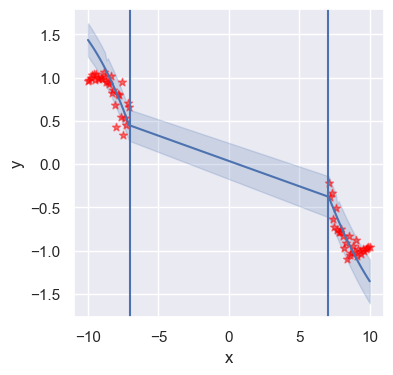

Epoch 149 | batch train loss: -1.339774250984192 | test loss: 0.04720544070005417
Epoch 149 |batch train mse:0.04212426021695137| test mse:0.04699581302702427


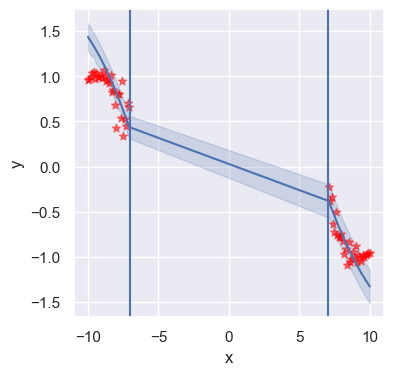

Epoch 149 | batch train loss: -0.8463606238365173 | test loss: -0.42789720464497805
Epoch 149 |batch train mse:0.09816253930330276| test mse:0.03762002009898424


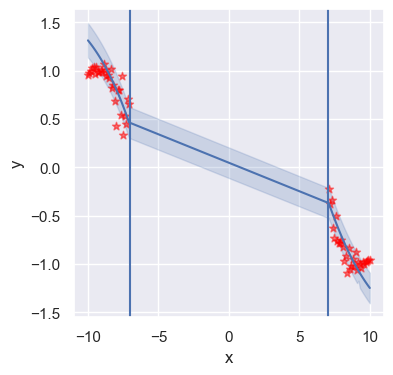

Epoch 149 | batch train loss: -1.2250690460205078 | test loss: -1.084009200334549
Epoch 149 |batch train mse:0.06739328801631927| test mse:0.024371519219130278


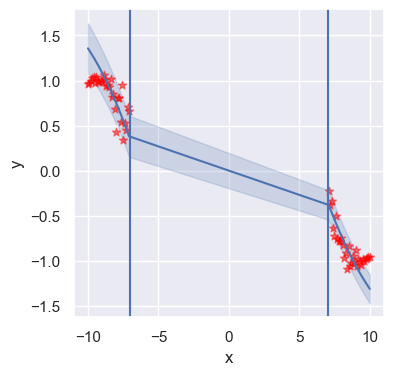

Epoch 149 | batch train loss: -1.4525913000106812 | test loss: -0.45118507742881775
Epoch 149 |batch train mse:0.04638442397117615| test mse:0.038917860481888056


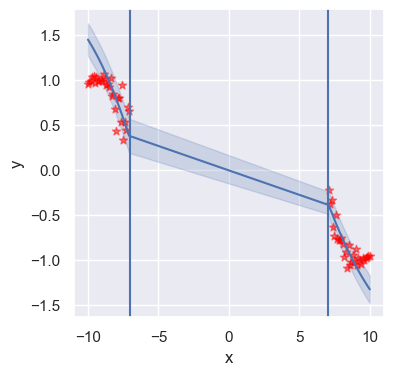

Epoch 149 | batch train loss: -0.9974161982536316 | test loss: -0.16258250176906586
Epoch 149 |batch train mse:0.10513404756784439| test mse:0.04280005116015673


In [21]:
train_losses_oodd=[]
test_losses_oodd=[]
errors_train_oodd=[]
errors_test_oodd=[]
for i in range(10):
  tr_loss,test_loss,mse_tr,mse_test = MLE_snn_oodd()
  train_losses_oodd.append(tr_loss)
  test_losses_oodd.append(test_loss)
  errors_train_oodd.append(mse_tr)
  errors_test_oodd.append(mse_test)

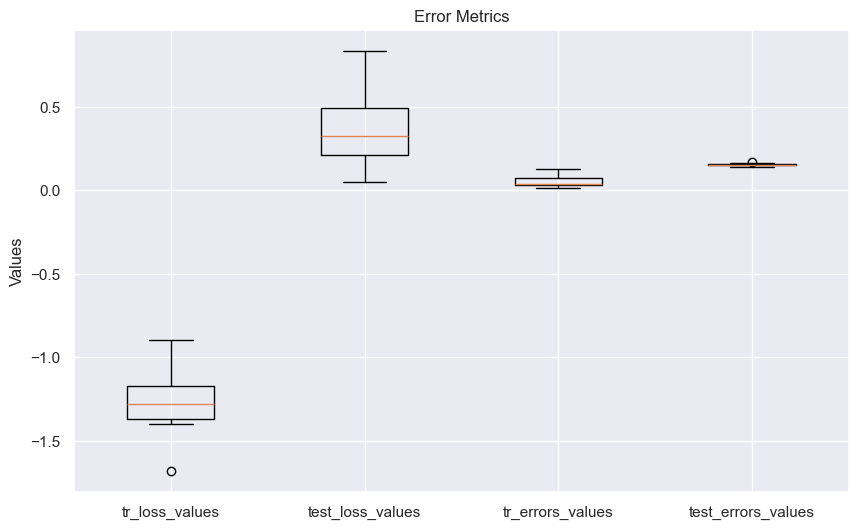

In [22]:
# Extract numerical values from the tensors and remove grad_fn
tr_loss_values= [tensor.item() for tensor in train_losses]
test_loss_values=test_losses
tr_errors_values= [tensor.item() for tensor in errors_train]
test_errors_values= errors_test

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Create box plots for each dataset
box_plot_data = [tr_loss_values, test_loss_values, tr_errors_values, test_errors_values]
box_labels = ['tr_loss_values', 'test_loss_values', 'tr_errors_values', 'test_errors_values']

ax.boxplot(box_plot_data, labels=box_labels)

# Add labels and title

ax.set_ylabel('Values')
ax.set_title('Error Metrics')

# Show the plot
plt.show()


In [23]:

mean_gaus_train_loss = np.mean(tr_loss_values)
std_dev_gaus_train_loss = np.std(tr_loss_values)

mean_gaus_test_loss = np.mean(test_loss_values)
std_dev_gaus_test_loss = np.std(test_loss_values)

mean_mse_train = np.mean(tr_errors_values)
std_dev_mse_train = np.std(tr_errors_values)

mean_mse_test = np.mean(test_errors_values)
std_dev_mse_test = np.std(test_errors_values)

print('Mean of Gausiann Training Loss of 10 runs ', mean_gaus_train_loss)
print('Standard Deviation of Gausiann Training Loss of 10 runs ' , std_dev_gaus_train_loss )

print('Mean of Gausiann Testing Loss of 10 runs ',mean_gaus_test_loss )
print('Standard Deviation of Gausiann Testing Loss of 10 runs ',std_dev_gaus_test_loss)

print('Mean of MSE Training of 10 runs ',mean_mse_train)
print('Standard Deviation of MSE Training of 10 runs ' , std_dev_mse_train)

print('Mean of MSE Testing of 10 runs ',mean_mse_test )
print('Standard Deviation of MSE Testing of 10 runs ', std_dev_mse_test)

Mean of Gausiann Training Loss of 10 runs  -1.2550585746765137
Standard Deviation of Gausiann Training Loss of 10 runs  0.21814479938971645
Mean of Gausiann Testing Loss of 10 runs  0.38840517527782004
Standard Deviation of Gausiann Testing Loss of 10 runs  0.24729900101204275
Mean of MSE Training of 10 runs  0.05326593620702624
Standard Deviation of MSE Training of 10 runs  0.038703239454908944
Mean of MSE Testing of 10 runs  0.1522402628683127
Standard Deviation of MSE Testing of 10 runs  0.00882228347913266


In [24]:
# Create a DataFrame from the lists
data = {
    'Training Loss': tr_loss_values,
    'Testing Loss': test_loss_values,
    'Mean Squared Training Error': tr_errors_values,
    'Mean Squared Testing Error': test_errors_values
}

num_columns = len(data)

column_names = ['Training Loss','Testing Loss', 'Mean Squared Training Error','Mean Squared Testing Error']

# Create a DataFrame with dynamic column names
df = pd.DataFrame(data, columns=column_names)
df.index += 1
# Display the DataFrame as a table
print(df)
df.to_csv('results_snn.csv', index=True)

    Training Loss  Testing Loss  Mean Squared Training Error  \
1       -1.679101      0.295056                     0.034557   
2       -1.171115      0.834926                     0.031390   
3       -1.175664      0.194338                     0.018664   
4       -0.929639      0.349860                     0.127102   
5       -0.895978      0.526443                     0.114463   
6       -1.364475      0.388745                     0.035921   
7       -1.373320      0.255201                     0.087206   
8       -1.397929      0.046834                     0.030224   
9       -1.275166      0.802562                     0.039745   
10      -1.288198      0.190085                     0.013388   

    Mean Squared Testing Error  
1                     0.149446  
2                     0.170893  
3                     0.151391  
4                     0.153251  
5                     0.149200  
6                     0.147253  
7                     0.156043  
8                     0.137924 

In [25]:
print(test_errors_values)

[0.1494462487216179, 0.17089273436711386, 0.15139088636407486, 0.1532512645308788, 0.14919982850551605, 0.1472532617358061, 0.15604252310899588, 0.1379240837234717, 0.16256067500664637, 0.14444112261900535]
